In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


In [ ]:
!pip install datasets

from datasets import load_dataset

ds = load_dataset("dair-ai/emotion", "split")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train=ds['train']
validation=ds['validation']
test=ds['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text']for x in data]
  labels=[x['label']for x in data]
  return tweets,labels

In [ ]:
tweets, labels= get_tweet(train)

In [ ]:
tweets[0],labels[0]

('i didnt feel humiliated', 0)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences(tweets[0])

[[2],
 [],
 [669],
 [2],
 [669],
 [1726],
 [43],
 [],
 [1997],
 [1550],
 [1550],
 [8884],
 [],
 [6051],
 [966],
 [93],
 [2],
 [8884],
 [2],
 [7],
 [43],
 [1550],
 [669]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

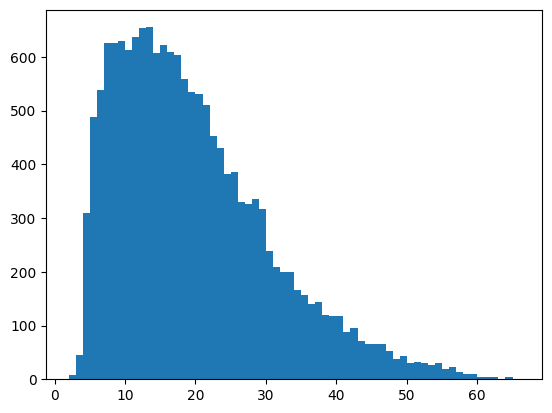

In [ ]:
#Creating padded sequences
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded_sequences=pad_sequences(sequences,truncating='post', padding='post',maxlen=maxlen)
  return padded_sequences

In [ ]:
padded_train_sequences=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes =set(labels)
print(classes)


{0, 1, 2, 3, 4, 5}


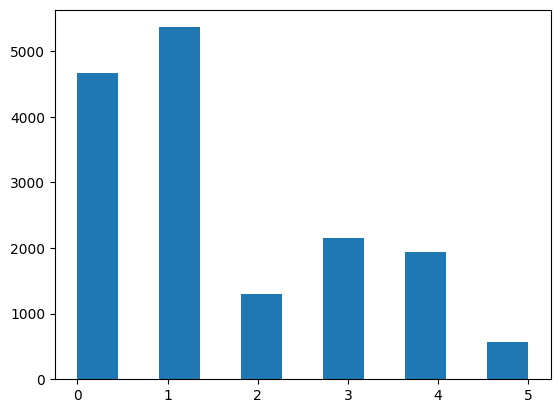

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
classes_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_classes=dict((v,k) for k,v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
names_to_ids= lambda labels:np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])


0


Creating Model

In [ ]:
import tensorflow as tf

maxlen = 50

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model with a specified input shape
model.build(input_shape=(None, maxlen))

# Now the model should print out with the correct parameter count
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming you have a function get_tweet that returns tweets and labels
validation_tweets, validation_labels = get_tweet(validation)

# Assuming you have a tokenizer and a function get_sequences to process the tweets
validation_seq = get_sequences(tokenizer, validation_tweets)

# Assuming you have a function names_to_ids to convert labels
validation_labels = names_to_ids(validation_labels)


In [ ]:
validation_tweets[0],validation_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(validation_seq, validation_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.8628 - loss: 0.4208 - val_accuracy: 0.8305 - val_loss: 0.4936
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9090 - loss: 0.2833 - val_accuracy: 0.8230 - val_loss: 0.5263
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9219 - loss: 0.2266 - val_accuracy: 0.8485 - val_loss: 0.4430
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9426 - loss: 0.1755 - val_accuracy: 0.8705 - val_loss: 0.4141
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.9629 - loss: 0.1193 - val_accuracy: 0.8670 - val_loss: 0.4584
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9724 - loss: 0.0958 - val_accuracy: 0.8760 - val_loss: 0.4249
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9739 - loss: 0.0878 - val_accuracy: 0.8880 - val_loss: 0.4224
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.9770 - loss: 0.0707 - 

evaluating the model

In [ ]:
import matplotlib.pyplot as plt

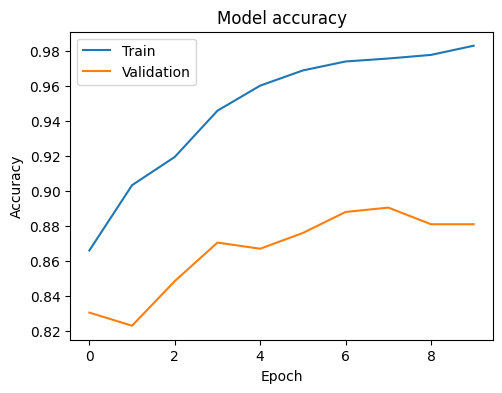

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

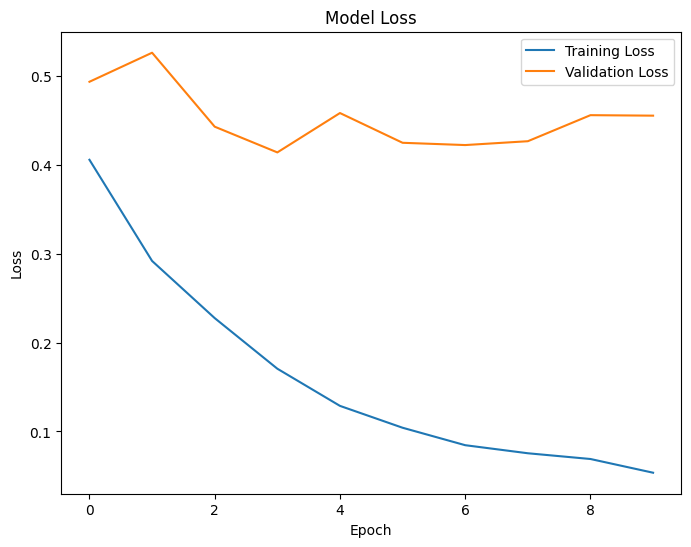

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [ ]:
_=model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8783 - loss: 0.4807


In [ ]:
import numpy as np
import random

# Assuming test_tweets, test_labels, test_seq, and index_to_classes are defined
i = random.randint(0, len(test_labels) - 1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

# Use model.predict and np.argmax to get the predicted class
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)


Sentence: i feel like a loser everyone says they lost but i dont i know exactly where i am i just hate being here oh
Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicted Emotion: 0


In [ ]:
import numpy as np

# Get the predicted probabilities for each class
pred_probs = model.predict(test_seq)

# Get the class with the highest probability
preds = np.argmax(pred_probs, axis=1)

# Now preds contains the predicted class indices for each input in test_seq


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


In [ ]:
pip install scikit-learn matplotlib


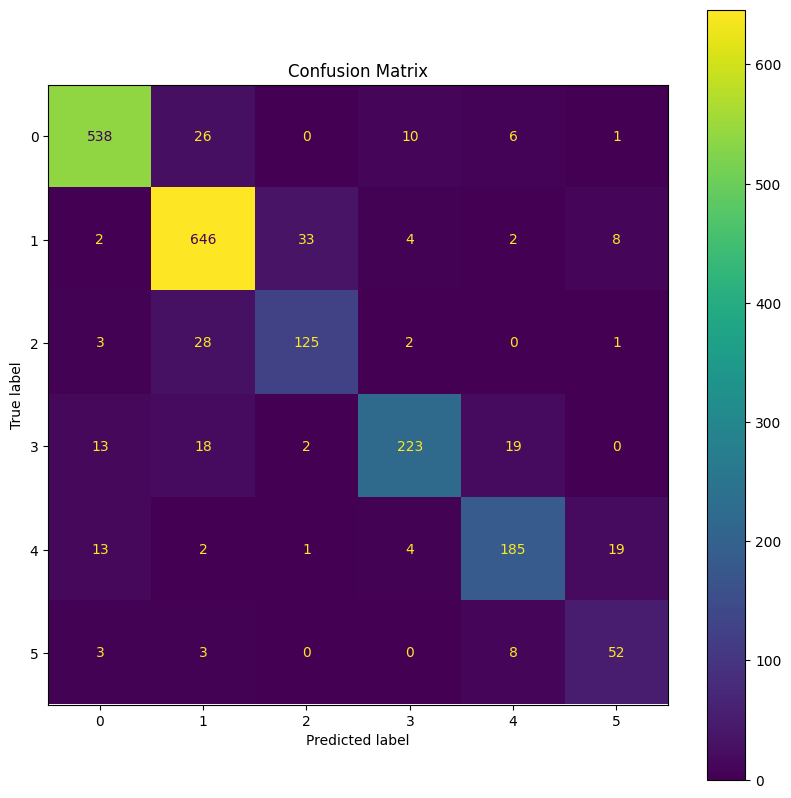

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_labels and preds are defined
cm = confusion_matrix(test_labels, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()
